In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import io

## The weather dataset
- 막스 플랑크 연구소에 제공한 기후 관련 데이터  
  * 14 개의 특성 정보(air temperature, atmospheric pressure, and humidity, etc)
  * 2003년 부터 매 10분 마다 측정된 데이터  
    * 한 시간 동안 6 개의 관측치 존재
    * 하루에 144 (6x24) 관측치가 포함
  * 효율적인 학습을 위해 2009 ~ 2016 데이터를 이용하여 학습 예정


In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path) #파일받아오기

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f805406cc90>],
      dtype=object)

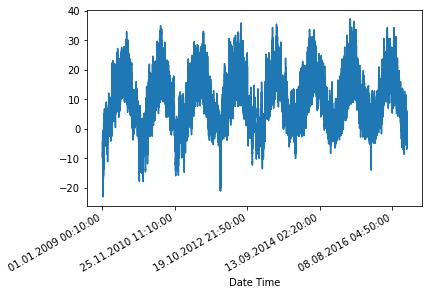

In [6]:
uni_data.plot(subplots=True)

# Step1. 학습데이터 load

In [7]:
data_url = 'https://codepresso-online-platform-public.s3.ap-northeast-2.amazonaws.com/learning-resourse/Tensorflow+2.0+%EB%94%A5%EB%9F%AC%EB%8B%9D+%EC%99%84%EB%B2%BD+%EA%B0%80%EC%9D%B4%EB%93%9C/univariate-temperature-codepresso.npz'

In [8]:
# requests 라이브러리를 이용해 데이터 다운로드
response = requests.get(data_url)
response.raise_for_status() # 에러가 있으면 에러 알람해줘!

# 다운로드 받은 데이터를 읽어 들여 Input tensor 와 Target tensor 준비
# context를 여는 상태로 물고 있는...
with np.load(io.BytesIO(response.content)) as tempt_codepresso_data: 
  # 학습 이미지 데이터(np.ndarry, shape=(299980, 20, 1))
  train_features = tempt_codepresso_data['train_features']
  # 학습 라벨 데이터(np.ndarry, shape=(299980,))
  train_labels = tempt_codepresso_data['train_labels']
  
  # 테스트 이미지 데이터(np.ndarry, shape=(120531, 20, 1))
  test_features = tempt_codepresso_data['test_features']
  # 테스트 라벨 데이터(np.ndarry, shape=(120531,))
  test_labels = tempt_codepresso_data['test_labels']

* 학습을 위한 univariate-temperature-codepresso.npz 데이터 셋 구성
  * 관찰기간 : 20(200분)
  * 관찰 점 당 feature의 개수 : 1 개(T (degC))
  * 예측 시퀀스 : 0(관찰기간 바로 뒤 시퀀스) 

In [9]:
train_features.shape, train_labels.shape

((299980, 20, 1), (299980,))

In [10]:
test_features.shape, test_labels.shape

((120531, 20, 1), (120531,))

In [11]:
def show_plot(plot_data, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = list(range(-plot_data[0].shape[0], 0))
  future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

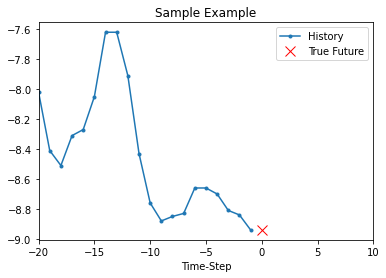

In [12]:
show_plot([train_features[0], train_labels[0]], 'Sample Example')

# Step2. Model 구조 설계  

In [13]:
from tensorflow.keras import models, layers

In [14]:
model = models.Sequential()

In [15]:
model.add(layers.SimpleRNN(units=8, input_shape=(20,1)))

model.add(layers.Dense(units=1)) # activation = 항등함수 (default)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 80        
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [17]:
wx = 1*8

wh = 8*8

b = 1*8

wx+wh+b

80

# Step3. Model의 학습에 필요한 설정 정보 세팅

In [18]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step4. Model에 학습데이터를 연결하여 학습

In [19]:
history = model.fit(x=train_features, y=train_labels, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10
938/938 [==============================] - 6s 5ms/step - loss: 87.6304 - mae: 6.7604 - val_loss: 56.6828 - val_mae: 5.2030
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 27.9392 - mae: 3.0056 - val_loss: 21.1751 - val_mae: 2.5282
Epoch 3/10
938/938 [==============================] - 4s 5ms/step - loss: 10.7208 - mae: 1.4943 - val_loss: 8.9846 - val_mae: 1.3203
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 4.5853 - mae: 0.8206 - val_loss: 4.2760 - val_mae: 0.7622
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 2.1324 - mae: 0.4996 - val_loss: 2.2190 - val_mae: 0.5010
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 1.0680 - mae: 0.3368 - val_loss: 1.2148 - val_mae: 0.3551
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.5709 - mae: 0.2521 - val_loss: 0.6910 - val_mae: 0.2758
Epoch 8/10
938/938 [==============================] - 4s 5ms/step - los

In [20]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) +1)

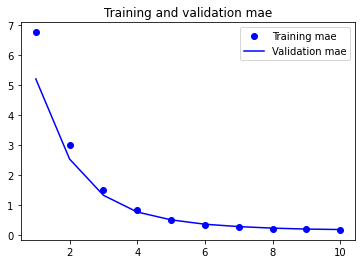

In [21]:
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

plt.show()

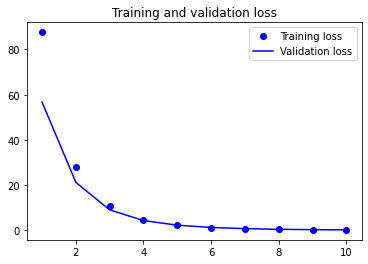

In [22]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Step6. Test 데이터셋을 이용한 모델의 성능 평가

In [25]:
loss, mae = model.evaluate(test_features, test_labels)

3767/3767 [==============================] - 7s 2ms/step - loss: 0.1953 - mae: 0.1777


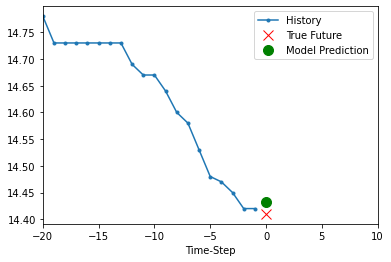

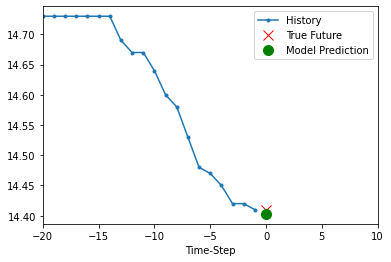

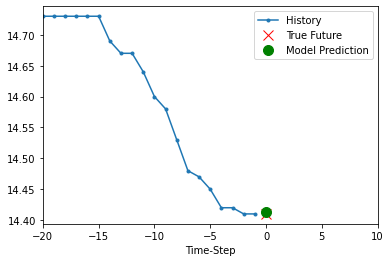

In [26]:
for x, y in zip(test_features[:3], test_labels[:3]):
  plot = show_plot([x, y, model.predict(x.reshape(1, 20, 1))[0]], '')
  plot.show()